<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/notebooks/PISTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>This notebook breaksdown the PISTA package</b></h1></center>

# **Install**

In [1]:
!pip install photutils --quiet
!pip install galsim

     |████████████████████████████████| 826 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43.7 MB 1.9 MB/s 
     |████████████████████████████████| 213 kB 66.2 MB/s 


# **GitHub**

In [2]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 1685, done.
remote: Counting objects: 100% (561/561), done.
remote: Compressing objects: 100% (266/266), done.
remote: Total 1685 (delta 298), reused 532 (delta 274), pack-reused 1124
Receiving objects: 100% (1685/1685), 303.20 MiB | 22.40 MiB/s, done.
Resolving deltas: 100% (910/910), done.


In [3]:
cd /content/INSIST/data

/content/INSIST/data


# **Imports**

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling.models import custom_model

from matplotlib import cm
from matplotlib.ticker import LogLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib import colors as col
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm

from photutils import aperture as aper
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture
from photutils.isophote import Ellipse
from photutils.centroids import centroid_com, centroid_quadratic
from photutils.centroids import centroid_1dg, centroid_2dg
from photutils.isophote import build_ellipse_model

from scipy.stats import norm
from scipy.interpolate import interp1d, interp2d, griddata
from scipy.integrate import trapz
from scipy.constants import c
import copy

import os
from time import perf_counter
import json
import requests


sb.set_style('darkgrid')
matplotlib.rcParams['font.size']=12
matplotlib.rcParams['figure.figsize']=(10,10)

# **Utils**

In [5]:
def bandpass(wav, flux , inputs, plot = True, fig = None, ax = None):
  """
  Function to convolve response functions

  Parameters
  ----------
  wav : numpy.ndarray 
        wavelenth in angstrom
  flux: numpy.ndarray
        flux normalized to [0,1]
  plot: bool,
        If true shows plots with input and convolved response functions

  fig : matplotlib.pyplot.figure
        User defined figure
  ax  : matplotlib.pyplot.axes
        User defined axes

  Returns
  -------

  fig, ax, data, params

  data : tuple,
        (wavelenth array, flux_array, convolved flux array)
  
  params: tuple,
          (effective wavelength, integrated flux, Effective Width)
  
  """
  lambda_   =  wav 
  flux_AB   = flux 

  if plot:
    if fig is None or ax is None:
        fig, ax = plt.subplots(1,1, figsize = (12,8))
    ax.plot(lambda_ ,flux_AB/flux_AB.max(),label = r'$F(\lambda)$', alpha = 0.7 )

  R_eff = 1

  for i in inputs:
    file_name = i.split(',')[0]
    n         = float(i.split(',')[1])
    
    filt_dat  = np.loadtxt(file_name)
    wav  = filt_dat[:,0]
    flux = filt_dat[:,1:]
    
    if flux.max()>50:
      flux/=100
    flux = flux.prod(axis = 1)

    indices  = np.where( (wav>lambda_ [0]) & (wav<lambda_[-1]))
    wav_new  = wav[indices]
    flux_new = flux[indices]
    
    wav_new  =  [lambda_ [0]] + [wav_new[0]- 1] + list(wav_new) + [wav_new[-1]+ 1] + [lambda_[-1]]
    flux_new =  [0]           + [0]             + list(flux_new) +   [0]           + [0]

    wav_new  = np.array(wav_new)
    flux_new = np.array(flux_new)

    filter_func = interp1d(wav_new,flux_new)

    flux_out    = filter_func(lambda_)

    R_eff      *= flux_out**n
    
    if plot:
      ax.plot(lambda_ ,flux_out/flux_out.max(),label=f"{file_name.split('/')[-1][:-4]}x{n}", alpha = 0.7)

  conv_flux = R_eff*flux_AB
 
  lambda_phot = trapz(lambda_**2*conv_flux,lambda_)/trapz(lambda_*conv_flux,lambda_)

  W_eff      = trapz(R_eff,lambda_)/R_eff.max()

  int_flux   = trapz(lambda_*conv_flux,lambda_)/trapz(lambda_*R_eff, lambda_)

  data       =  lambda_, flux_AB, conv_flux
  params     =  lambda_phot, int_flux, W_eff

  if plot:
    ax.plot(lambda_,conv_flux/conv_flux.max(),label = 'Convloved Flux')
    y = np.linspace(0,1)
    x = y*0 + lambda_phot
    label = r'$\lambda_{phot} = $' + f'{round(lambda_phot,3)}' + r' $\AA$'
    ax.plot(x,y,'--', color = 'black',label = label )
   
    ax.set_xlabel(r'$\AA$')
    ax.set_ylabel(r'Normalized Flux')
    ax.legend()
    
  return fig, ax, data, params

In [6]:
def generate_psf(npix,sigma, function = 'Gaussian'):

    """
    Function for generating user defined PSF

    npix : int,
           number of pixels along one axis for pixel array
    
    sigma: float,
           standard deviation of the PSF in pixels

    function: str,
               type of PSF function
    
    Returns
    -------

    numpy.ndarray
    
    """
    x       = np.linspace(0,1000,npix)
    y       = x
    yy,xx   = np.meshgrid(x,y)
    if function == 'Gaussian':
        psf     = models.Gaussian2D(1,500,500,sigma,sigma)(xx,yy)
        psf/=psf.sum()
    np.save('user_defined_psf.npy',psf)
    return psf

# **Simulator**

In [8]:
class Imager():
  def __init__(self, df, coords, tel_params, n_x, n_y, exp_time, **kwargs):   
    """Image simulation using Source catalog. Class which simulates the field 
    and creates image

    Parameters
    ----------

    df     : pd.DataFrame, 
             Pandas dataframe with source catalog

    coords : (float, float),
             (RA, Dec) in degrees

    tel_params : dict, 
                 {'aperture'       : float,  cm
                  'pixel_scale'    : float,  arcsecs/pixels
                  'sim_file'       : fits,npy 
                  'response_funcs' : list, [filename.dat, n] where n is 
                                          number of times to multiply filter
                                          profile
                  'coeffs'         : float, filter coefficients if not
                                          response_funcs
                  } 
    n_x      : int, 
               number of pixels along RA direction
    n_y      : int, 
               number of pixels along Dec direction
    exp_time : float, 
               Exposure time in seconds 

    """
    self.df     = df
    if coords is None:
      self.ra  = (self.df['ra'].max()+self.df['ra'].min())/2
      self.dec = (self.df['dec'].max()+self.df['dec'].min())/2
    else:
      self.ra  = coords[0]
      self.dec = coords[1]

    # Flags
    self.shot_noise = True
    self.QE         = True
    self.sky        = True
    self.PRNU       = True
    self.DC         = True
    self.DNFP       = True
    self.QN         = True
    self.cosmic_rays= False

    data_path  = '/content/INSIST/src/pista/data'

    # Parameters
    self.tel_params = {'aperture'       : 100, # cm
                       'pixel_scale'    : 0.1,
                       'psf_file'       :f'{data_path}/PSF/INSIST/on_axis_hcipy.npy',
                       'response_funcs' : [],
                       'coeffs'         : 1
                       }
    
    if tel_params is not None:
      self.tel_params.update(tel_params)
    self.tel_params.update(kwargs)

    self.det_params = {'shot_noise': 'Gaussian',
                      'M_sky'      :  27,
                      'qe_sigma'   :  0.01,       # Pixel to pixel fluctuation
                      'bias'       :  35,         # electrons
                      'G1'         :  1,
                      'bit_res'    :  14,         
                      'RN'         :  5,          # elec/pix
                      'PRNU_frac'  :  0.25/100,   # PRNU sigma
                      'T'          :  223,        # K
                      'DFM'        :  1.424e-2,   # 14.24 pA
                      'pixel_area' :  1e-6,       # 
                      'DN'         :  0.1/100,    # 
                      'NF'         :  0,          # electrons 
                      'FWC'        :  1.4e5,      # electrons 
                      'C_ray_r'    :  2/50        # hits/second
                   }
    self.det_params.update(kwargs)

    self.n_x = n_x
    self.n_y = n_y

    self.n_x_main  = n_x
    self.n_y_main  = n_y

    self.pixel_scale    = self.tel_params['pixel_scale']

    self.response_funcs = self.tel_params['response_funcs']
    self.coeffs         = self.tel_params['coeffs']

    self.gain           = self.det_params['G1']*pow(2,
                            self.det_params['bit_res'])/self.det_params['FWC'] # DN/electrons
    self.tel_area       = np.pi*(self.tel_params['aperture']/2)**2
                            
    self.exp_time       = exp_time  # seconds
    self.sim_run        = False 
    
    self.psf_file       = self.tel_params['psf_file']

    if self.df is not None:
        self.init_sim_patch() 
        if self.n_pix_sub%2!=0:
          n_x += self.n_pix_sub - 1
          n_y += self.n_pix_sub - 1
        else:
          n_x += self.n_pix_sub
          n_y += self.n_pix_sub
        self.init_df( self.ra, self.dec, n_x , n_y)
    else:
        print("df cannot be None")

    area = ((n_x*self.pixel_scale)/3600)*((n_y*self.pixel_scale)/3600)

    eff_area = (0.17/area)*self.exp_time
    
    self.n_cosmic_ray_hits = int(eff_area*self.det_params['C_ray_r'])

  def init_sim_patch(self, return_psf = False):
      
    if len(self.response_funcs)>0:

        wav  = np.linspace(1000,10000,10000)
        flux = (c*1e2*3.631e-20)/(wav**2*1e-8)   # AB flux
        
        fig, ax, data, params = bandpass(wav,flux,self.response_funcs
                                         , plot = False)
        
        lambda_phot, int_flux, W_eff = params
    
        self.lambda_phot = lambda_phot
        self.int_flux    = int_flux
        self.W_eff       = W_eff
        self.int_flux_Jy = (int_flux*lambda_phot**2*1e-8)/(c*1e2*1e-23)
        
        self.photons     = 1.51e3*self.int_flux_Jy*(W_eff/lambda_phot)
        
        self.zero_mag    = self.exp_time*self.tel_area*self.photons*self.coeffs
     
        filt_dat  = np.loadtxt(f'/content/INSIST/src/pista/data/Sky_mag.dat')
        wav  = filt_dat[:,0]
        flux = filt_dat[:,1]
    
        fig, ax, data, params= bandpass(wav,flux,self.response_funcs
                                         , plot = False)
        
        lambda_eff, int_flux, W_eff = params
        self.det_params['M_sky'] = int_flux
        self.M_sky_p         = self.det_params['M_sky'] - 2.5*np.log10(self.pixel_scale**2)

    else :
      self.zero_mag =  self.exp_time*(1.51e3*1000/2250)*self.tel_area*3631*self.coeffs
      self.M_sky_p  = self.det_params['M_sky'] - 2.5*np.log10(self.pixel_scale**2)

    ext = self.psf_file.split('.')[-1]
    
    if ext=='npy':
        image =  np.load(self.psf_file)
    elif ext=='fits':
        image = fits.open(self.psf_file)[0].data
         
    image            /= image.sum()  # Flux normalized to 1
    self.image_g_sub  = image
    F_sky_p           = self.zero_mag*pow(10,-0.4*self.M_sky_p)
    self.sky_bag_flux = F_sky_p    
    self.zero_flux    = self.zero_mag

    self.n_pix_sub  = self.image_g_sub.shape[0]

    if return_psf:
      return image*self.zero_flux

  def init_df(self, ra, dec,n_x, n_y):   

      self.fov_x   = (n_x*self.pixel_scale)/3600 # Degrees 
      self.fov_y   = (n_y*self.pixel_scale)/3600 # Degrees 

      height       = self.fov_x/2
      width        = self.fov_y/2  
      
      # Cropping Dataframe based on FoV
      ra_min  = (self.df['ra']>=ra - height) 
      ra_max  = (self.df['ra']<=ra + height)
      self.df = self.df[ ra_min & ra_max ]

      dec_min = (self.df['dec']>=dec - width)
      dec_max = (self.df['dec']<=dec + width)
      self.df = self.df[ dec_min & dec_max ]

      self.height = height
      self.width  = width
    
      self.name = f" RA : {np.round(ra,3)} degrees, Dec : {np.round(dec,3)} degrees"

  def init_image_array(self, return_img = False):
    """
    Creates a base image array for adding photons

    Parameters
    ----------
    return_img : bool, optional
        DESCRIPTION. The default is False.

    Returns
    -------
    numpy.ndarray
        if return_img is true return base image array
 
    """    
    if self.n_pix_sub%2!=0:
        self.n_x_main += 2*(self.n_pix_sub -1)
        self.n_y_main += 2*(self.n_pix_sub -1)
    else:
        self.n_x_main += 2*self.n_pix_sub
        self.n_y_main += 2*self.n_pix_sub

    self.image    = np.zeros((self.n_y_main, self.n_x_main)) # n
    self.wcs      = self.create_wcs(self.n_x_main, self.n_y_main,
                                    self.ra, self.dec, self.pixel_scale)
    if return_img:
      return self.image, self.wcs

  def create_wcs(self,n_x, n_y, ra,dec,pixel_scale):
    """
    Parameters
    ----------
    n_x : int
        number of pixels in RA direction
    n_y : int
        number of pixels in Dec direction
    ra : float (degrees)
        right ascension of center of image.
    dec : float (degrees)
        declination of center of image.
    pixel_scale : floats
        arcsecs/pixel.

    Returns
    -------
    w : wcs object

    """ 
    w = WCS(naxis=2)
    w.wcs.crpix = [(n_x-1)//2, (n_y-1)//2]
    w.wcs.cdelt = np.array([-pixel_scale/3600, self.pixel_scale/3600])
    w.wcs.crval = [ra, dec]
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    return w

  def compute_coeff_arrays(self):
    """
    
    Computed coefficients based on input parameters
    Returns
    -------
    None.
    """
    n_x = self.n_y_main #- self.n_pix_sub-1
    n_y = self.n_x_main

    if self.QE:
        self.qe_array =  np.random.normal(loc=0, 
                                          scale=self.det_params['qe_sigma'],
                                          size=(n_x, n_y))
    else:
      self.qe_array = 0

    self.bias_array =  np.random.normal(loc=self.det_params['bias'], 
                                      scale=self.det_params['RN'],
                                      size=(n_x, n_y))
    if self.PRNU:

      self.PRNU_array =  np.random.normal(loc=0, 
                                        scale = self.det_params['PRNU_frac'],
                                        size=(n_x, n_y))
    else:
       self.PRNU_array = 0
       
    if self.DC:
      self.DR = self.dark_current(self.det_params['T'], self.det_params['DFM'], 
                                  self.det_params['pixel_area'])

      self.DC_array = np.random.normal(loc = self.DR*self.exp_time, 
                                          scale = np.sqrt(self.DR*self.exp_time),
                                          size=(n_x, n_y))
    else: 
        self.DC_array = 0
    if self.DNFP and self.DC:
      self.DNFP_array =  np.random.lognormal(mean= 0, 
                                    sigma = self.exp_time*self.DR*self.det_params['DN'],
                                    size=(n_x, n_y))
      self.DC_array*=(1 + self.DNFP_array)
    else:
        self.DNFP_array = 0

    if self.QN:
      self.QN_value = (self.det_params['FWC']/(pow(2,self.det_params['bit_res']) #electrons
                                            *np.sqrt(12)))

      self.QN_array = self.QN_value*np.random.randint(-1,2,size = (n_x,n_y))
    else :
      self.QN_array = 0

  def dark_current(self,T, DFM, pixel_area):
    """
      Parameters
      ----------
      T : float
          Detector Temperature
      DFM : float
          Dark current figure of merit
      pixel_area : float
          Area of pixel

      Returns
      -------
      DR : float
         Dark current rate e/s/pixels

      """
    Kb  = 8.62e-5
    const	= 2.55741439581387e15

    EgT	= 1.1557 - (7.021e-4*T**2/(1108+T))
    DR	= const*pixel_area*(T**1.5)*DFM*np.exp(-EgT/(2*Kb*T))
    return DR
    
  def generate_photons(self, image, patch_width, df):
    """
      This function creates sims based on ABmag  on a 
      small patch (2D array) of size n_pix_s*n_pix_s. 
      
      The patch with the sim is then added to the image array of size 
      n_pix_m*n_pix_m using wcs object.

      Parameters
      ----------
      image       : numpy.ndarray
                    base image array for inserting star sims
      patch_width : int
                    number of pixels (length) in sim patch image
      df          : pandas.dataframe
                    Dataframe containing source list
          

      Returns
      -------
      image : numpy.ndarray
          Array with sims added based on df

      """
    patch_width_mid = patch_width//2

    for i, row in df.iterrows():

        c     = SkyCoord(row['ra'],row['dec'],unit=u.deg)
        pix   = self.wcs.world_to_array_index(c) # (RA, Dec) to pixel position
        ABmag = row['mag']

        flux  = self.zero_flux*10**(-ABmag/2.5)  # Photo-elec per second

        patch =  flux*self.image_g_sub           # Generating star using sim
    
        x1 = pix[0] - patch_width_mid
        x2 = x1     + patch_width
        y1 = pix[1] - patch_width_mid
        y2 = y1     + patch_width
        
        image[x1:x2, y1:y2] += patch
        
    image = image[2*patch_width_mid:-2*patch_width_mid,  # Cropping Image
                  2*patch_width_mid:-2*patch_width_mid]

    return image

  def compute_shot_noise(self,array,type_ = 'Gaussian'):
    """

    Parameters
    ----------
    array : numpy.ndarray
        input array
    type_ : str, optional
         The default is 'gaussian'.

    Returns
    -------
    shot_noise : numpy.ndarray
         Return array with shot noise
    """

    if type(array) == np.float64 :
      n_x = self.n_y_main
      n_y = self.n_x_main

    else :
      n_x = array.shape[0]
      n_y = array.shape[1]

    if type_ == 'Gaussian':
        shot_noise = np.random.normal(loc=array, scale=np.sqrt(array), 
                                      size = (n_x, n_y))
    elif type_ =='Poisson':
        shot_noise = np.random.poisson(lam=array,
                                       size = (n_x, n_y)).astype(array.dtype)
    else:
      print('Invalid type')

    return shot_noise  


  def __call__(self,det_params = None,n_stack =1,stack_type = 'median'):
    """
     Parameters
     ----------
    det_params: dict, optional  
     Dictionary contianing detector parameters. The default is None.
                {     'shot_noise' :  str,
                      'M_sky'      :  float,
                      'qe_sigma'   :  float,       Pixel to pixel fluctuation
                      'bias'       :  float,       electrons
                      'G1'         :  float,
                      'bit_res'    :  int,         
                      'RN'         :  float,       elec/pix
                      'PRNU_frac'  :  float,       PRNU sigma
                      'T'          :  float,       K
                      'DFM'        :  float,       pA
                      'pixel_area' :  float,       
                      'DN'         :  float,     
                      'NF'         :  float,       electrons 
                      'FWC'        :  float,       electrons 
                      'C_ray_r'    :  float        hits/second
                  }
                   
     n_stack    : int, optional
                  Number of observations to be stacked. The default is 1.

     stack_type : str, optional
                  Stacking method. The default is 'median'.
     
     
    Simulates field by taking dataframe as input by inserting sim patches in 
    image array using WCS
     Returns
     -------
     numpy.ndarray
     Final image array after adding all layers of simulation
    
    """
    self.sim_flag = True
    if det_params is not None:

      self.det_params.update(det_params)
      self.gain        = self.det_params['G1']*pow(2,
                         self.det_params['bit_res'])/self.det_params['FWC']
      self.M_sky_p     = self.det_params['M_sky'] - 2.5*np.log10(self.pixel_scale**2)
      self.init_sim_patch() 

    digital_stack = []
    self.compute_coeff_arrays()
    
    for i in range(n_stack):

      self.init_image_array()
      
      self.source_photons   = self.generate_photons(self.image, self.n_pix_sub,
                                                    self.df)
      
      if self.shot_noise:
         self.source_photons  = self.compute_shot_noise(self.source_photons 
                              ,type_ = self.det_params['shot_noise'])
 
      self.source_photoelec = self.source_photons*(1+self.qe_array)
         
      self.n_x_main = self.source_photoelec.shape[1]
      self.n_y_main = self.source_photoelec.shape[0]

      if self.sky:
        self.sky_photoelec = self.compute_shot_noise(self.sky_bag_flux,
                                                     'Gaussian')*(1+ self.qe_array)
        
        self.light_array = self.source_photoelec +  self.sky_photoelec
      else:
        self.light_array = self.source_photoelec

      if self.PRNU:
        self.light_array*=(1+self.PRNU_array)

      if self.DC:
        self.photoelec_array = self.light_array + self.DC_array
      else:
        self.photoelec_array  = self.light_array

      self.charge = self.photoelec_array + self.QN_array + self.det_params['NF'] + self.bias_array 
      
      self.digital = (self.charge*self.gain).astype(int)

      # Full well condition
      self.digital = np.where(self.digital>=pow(2, self.det_params['bit_res']),pow(2, self.det_params['bit_res']), self.digital)
      
      digital_stack.append(self.digital)
    
    digital_stack = np.array(digital_stack)
    if n_stack>1:
      if stack_type   == 'median':
        self.digital  = np.median(digital_stack, axis = 0)
      elif stack_type == 'mean':
        self.digital  = np.median(digital_stack, axis = 0)
        
    if self.cosmic_rays:
        for i in range(self.n_cosmic_ray_hits):
          x = np.random.randint(0,self.n_x_main)
          y = np.random.randint(0,self.n_y_main)
          self.digital[x,y] = pow(2, self.det_params['bit_res'])


    self.init_df(self.ra, self.dec, self.n_x_main, self.n_y_main)
    self.wcs = self.create_wcs(self.n_x_main,self.n_y_main, 
                               self.ra,self.dec, self.pixel_scale)

    self.header = self.wcs.to_header()
    
    return self.digital

## **Photometry**

In [9]:
class Analyzer(Imager):
  def __init__(self, df = None, coords = None,tel_params=None,exp_time = 100,
               n_x = 1000, n_y = 1000, **kwargs):
      
      super().__init__(df=df, coords=coords, exp_time = exp_time, n_x = n_x,
                       n_y = n_y, tel_params=tel_params, **kwargs)
      """
      A class to visualize and analyze the simulated image
      
      Parameters
      ----------
      Imager.init() 

      Returns
      -------
      None.

      """
  def __call__(self,det_params= None, n_stack =1, stack_type ='median', 
               do_photometry =True):
    super().__call__(det_params = det_params, n_stack = n_stack, 
                     stack_type = stack_type)
    """
    
    Performs sim simulation and sim Photometry
    
    Imager.call()

    do_photometry : Bool, Default : True
                    Do Aperture Photometry 
    """
    
    if do_photometry and len(self.df)>1:
      self.data_jy, self.phot_table = self.photometry(self.digital.astype(float),
                                                   self.wcs,self.df)
  def photometry(self,data,wcs,df):

      c          = SkyCoord(df['ra'], df['dec'],unit=u.deg)
      pix        = wcs.world_to_array_index(c)

      position   = [(i,j) for i,j in zip(pix[1],pix[0])]

      self.aps   = aper.CircularAperture(position, r=0.3/0.1)
      ap_pix     = np.count_nonzero(self.aps.to_mask()[0])
      self.bags  = aper.CircularAnnulus(position, r_in = 0.6/0.1, r_out = 1/0.1)
      bag_pix    = np.count_nonzero(self.bags.to_mask()[0])
     
      phot_table      = aperture_photometry(data, [self.aps, self.bags])

      phot_table['sky_flux'] = phot_table['aperture_sum_1']*(ap_pix/bag_pix)
      phot_table['flux']     = phot_table['aperture_sum_0'].value - phot_table['sky_flux'].value
      phot_table['flux_err'] = np.sqrt( phot_table['flux'].value  + phot_table['sky_flux'].value )
  
      phot_table['SNR']      = phot_table['flux'].value/ phot_table['flux_err'].value
      phot_table['mag_in']   = df['mag'].values
      
      if len(phot_table)>3:
      
        zero_p_flux = 0
        for i in range(3):
          zero_p_flux += phot_table['flux'].value[i]/pow(10,
                                        -0.4*phot_table['mag_in'].value[i])
        zero_p_flux/=3
        print('Estimated Zero point using 3 stars')
      elif len(phot_table)>0:
          zero_p_flux = 0
          for i in range(len(phot_table)):
            zero_p_flux += phot_table['flux'].value[i]/pow(10,
                                         -0.4*phot_table['mag_in'].value[i])
            zero_p_flux/=len(phot_table)
      else:
        zero_p_flux = self.zero_flux*self.exp_time
        
      data_jy= data*(3631/zero_p_flux)
      
      self.header['EXPTIME'] = self.exp_time
      self.header['ZPT']     = zero_p_flux
      self.header['BUNIT']   = 'DN'
      phot_table['mag_out']  = -2.5*np.log10(phot_table['flux']/zero_p_flux)
      phot_table['mag_err']  = 1.082/phot_table['SNR']

      self.phot_table = phot_table

      return data_jy, phot_table

  def show_field(self,figsize=(10,10)):
    """
    Function for creating a scatter plot of sources within the FoV
    
    Parameters
    ----------
    figsize : tuple,
              Figure size

    Returns
    -------
    fig, ax
    """
    if self.wcs is None :
      self.init_image_array()

    # Cropping data frame to show source within n_x x n_y
    
    fov_x   = (self.n_x*self.pixel_scale)/3600 # Degrees 
    fov_y   = (self.n_y*self.pixel_scale)/3600 # Degrees 

    height  = fov_x/2
    width   = fov_y/2  
    
    ra_min  = (self.df['ra']>=self.ra - height) 
    ra_max  = (self.df['ra']<=self.ra + height)
    df = self.df[ ra_min & ra_max ]

    dec_min = (df['dec']>=self.dec - width)
    dec_max = (df['dec']<=self.dec + width)
    df      = df[ dec_min & dec_max ]

    fov_x  = np.round(fov_x, 3)
    fov_y  = np.round(fov_y, 3)

    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.scatter(df['ra'],df['dec'],marker='.',color='black')
    ax.set_title(f"""Requested Center : {self.name} | {len(df)} sources
    Fov(RA) : {fov_x} | Fov(Dec) : {fov_y} """)
    ax.invert_xaxis()
    ax.set_xlabel('RA (Degrees)')
    ax.set_ylabel('Dec (Degrees)')
    return fig,ax

  def show_image(self, source = 'Digital', fig = None, ax = None,cmap = 'jet', 
                 figsize = (15,10), download = False, show_wcs = True):
    """
    Function for plotting the simulated field image

    Source: str,
            Choose from
                         'Digital' : Final digial image
                         'Charge'  : electrons, Light(Source + sky) + Dark Current + Noises
                         'Source'  : Source + Sky + Noises
                         'Sky'     : Sky + shot_noise
                         'DC'      : Dark Current + DNFP
                         'QE'      : Quantum efficiency fluctuation across detector
                         'Bias'    : Charge offset
                         'PRNU'    : Photon Response Non-Uniformity
                         'DNFP'    : Dark Noise Fixed Pattern
                         'QN'      : Quantization Noise


    fig : matplotlib.pyplot.figure
          User defined figure
    ax  : matplotlib.pyplot.axes
          User defined axes
    cmap : str,
           matplotlib.pyplot colormap
    figsize : tuple
    download : bool
    show_wcs : bool
               If true adds WCS projection to the image
    Returns
    -------
    Image

    fig, ax
    """
    if np.all(self.image) !=None :
        if fig is None or ax is None:
            fig = plt.figure(figsize = figsize)
        norm = None
        
        if source == 'Digital':
          data  = self.digital
          norm = col.LogNorm()
        elif source =='Charge':
          data  = self.charge
          norm = col.LogNorm()
        elif source =='Source':
          data  = self.light_array
          norm = col.LogNorm()
        elif source == 'Sky':
          data = self.sky_photoelec
        elif source == 'DC':
          data = self.DC_array
        elif source == 'QE':
          data = self.qe_array
        elif source =='Bias':
          data = self.bias_array + self.DC_array 
        elif source == 'PRNU':
          data = self.PRNU_array
        elif source == 'DNFP':
          norm = col.LogNorm()
          data = self.DNFP_array
        elif source == 'QN':
          data = self.QN_array
        else:
          print("Invalid Input")
          return None
    
        if show_wcs:
            ax = fig.add_subplot(projection=self.wcs)
        else:
            ax = fig.add_subplot()
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth('3') 
        img = ax.imshow(data,cmap=cmap , norm = norm)
        plt.colorbar(img,ax = ax)
        ax.set_title(f'{source} \nRequested center : {self.name}')
        ax.grid(False)
        if download:
            fig.savefig(f"{source}.png", format = 'png')
        return fig,ax
    else:
        print("Run Simulation")
        
  def show_hist(self, source = 'Digital',bins = None,
                 fig = None, ax = None,figsize=(15,8)):
    """
    Function for plotting histogram of various stages of simulation

    Parameters
    ----------

    Source: str,
            Choose from
                      'Digital' : Final digial image
                      'Charge'  : electrons, Light(Source + sky) + Dark Current + Noises
                      'Source'  : Source + Sky + Noises
                      'Sky'     : Sky + shot_noise
                      'DC'      : Dark Current + DNFP
                      'QE'      : Quantum efficiency fluctuation across detector
                      'Bias'    : Charge offset
                      'PRNU'    : Photon Response Non-Uniformity
                      'DNFP'    : Dark Noise Fixed Pattern
                      'QN'      : Quantization Noise

    bins : numpy.array,
           bins for making histogram
    fig : matplotlib.pyplot.figure
          User defined figure
    ax  : matplotlib.pyplot.axes
          User defined axes
    figsize : tuple
    """
   
    if np.all(self.image) !=None :
        if fig is None or ax is None: 
            fig, ax = plt.subplots(1,1,figsize=figsize)
    
        if source == 'Digital':
          data  = self.digital.ravel()
        elif source =='Charge':
          data  = self.charge.ravel()
          norm = col.LogNorm()
        elif source =='Source':
          data  = self.light_array
        elif source == 'Sky':
          data = self.sky_photoelec.ravel()
        elif source == 'DC':
          data = self.DC_array.ravel()
        elif source == 'QE':
          data = self.qe_array
        elif source =='Bias':
          data = (self.bias_array + self.DC_array).ravel()
        elif source == 'PRNU':
          data = self.PRNU_array.ravel()
        elif source == 'DNFP':
          data = self.DNFP_array.ravel()
        elif source == 'QN':
          data = self.QN_array.ravel()
    
        if bins is None:
          bins  = np.linspace(data.min(), data.max(), 20)
        ax.hist(data, bins = bins)
        ax.set_title(f'{source} histogram')
        ax.set_ylabel('Count')
        ax.set_yscale('log')
        return fig, ax
    else:
        print("Run Simulation")

  def getImage(self,source = 'Digital'):
    """
    Function of retrieving image array at different stages of simulation.

    Parameters
    ----------

    Source: str,
        Choose from
                      'Digital' : Final digial image
                      'Charge'  : electrons, Light(Source + sky) + Dark Current + Noises
                      'Source'  : Source + Sky + Noises
                      'Sky'     : Sky + shot_noise
                      'DC'      : Dark Current + DNFP
                      'QE'      : Quantum efficiency fluctuation across detector
                      'Bias'    : Charge offset
                      'PRNU'    : Photon Response Non-Uniformity
                      'DNFP'    : Dark Noise Fixed Pattern
                      'QN'      : Quantization Noise
    """
      
    if np.all(self.image) !=None :
        if source == 'Digital':
            data  = self.digital
        elif source =='Charge':
            data  = self.charge
        elif source == 'Sky':
            data = self.sky_photoelec
        elif source == 'DC':
            data = self.DC_array
        elif source == 'QE':
            data = self.qe_array
        elif source =='Bias':
            data = (self.bias_array + self.DC_array)
        elif source == 'PRNU':
            data = self.PRNU_array
        elif source == 'DNFP':
            data = self.DNFP_array
        elif source == 'QN':
            data = self.QN_array
        else:
            data = 0
        return data
    else:
      print("Run Simulation")

  def writeto(self,name,source = 'Digital', user_source = None):

    """
    Function for downloading a fits file of simulated field image

    Parameters
    ----------
    name : str
           filename, Example : simulation.fits

    Source: str,
        Choose from
                      'Digital' : Final digial image
                      'Charge'  : electrons, Light(Source + sky) + Dark Current + Noises
                      'Source'  : Source + Sky + Noises
                      'Sky'     : Sky + shot_noise
                      'DC'      : Dark Current + DNFP
                      'QE'      : Quantum efficiency fluctuation across detector
                      'Bias'    : Charge offset
                      'PRNU'    : Photon Response Non-Uniformity
                      'DNFP'    : Dark Noise Fixed Pattern
                      'QN'      : Quantization Noise

    user_source : numpy.ndarray
                  2D numpy array user wants to save as FITS
    """
    if np.all(self.image) !=None :
      if user_source is not None and type(user_source)==np.ndarray:
        data = user_source
      elif source == 'Digital':
        data  = self.digital
        norm = col.LogNorm()
      elif source =='Charge':
        data  = self.charge
        norm = col.LogNorm()
      elif source =='Source':
          data  = self.light_array
      elif source == 'Sky':
        data = self.sky_photoelec
      elif source == 'DC':
        data = self.DC_array
      elif source == 'QE':
        data = self.qe_array
      elif source =='Bias':
        data = self.bias_array + self.DC_array 
      elif source == 'PRNU':
        data = self.PRNU_array
      elif source == 'DNFP':
        norm = col.LogNorm()
        data = self.DNFP_array
      elif source == 'QN':
        data = self.QN_array
    
      else:
        print(f"{source} is not a valid source")

      hdu = fits.PrimaryHDU(data, header = self.header)
      hdu.wcs = self.wcs
      hdul = fits.HDUList([hdu])
      hdul.writeto(f'{name}',overwrite= True)
    else:
      print("Run Simulation")

In [10]:
class Mosaic(Analyzer):
  """
  A class to split bigger images to tiles and stitch them together

  """

  def __init__(self, df = None, coords = None,tel_params=None,exp_time = 100,
               n_x = 1000, n_y  = 1000, mos_n = 1, mos_m = 1, **kwargs):
    
      """
      Analyzer.init()

      Parameters
      ----------
      mos_n : int,
              number of tiles in RA direction

      mos_m : int,
              number of tiles in Dec direction
      """

      super().__init__(df=df, coords=coords, exp_time = exp_time, n_x = n_x, 
                    n_y = n_y, tel_params=tel_params, **kwargs)
      
      self.n = mos_n
      self.m = mos_m

      self.mosaic_img, _ = self.init_image_array(return_img = True)
      patch_width_mid    = self.n_pix_sub//2

      self.mosaic_img=self.mosaic_img[2*patch_width_mid:-2*patch_width_mid,
                  2*patch_width_mid:-2*patch_width_mid]

      self.mosaic_name = self.name    
      self.mosaic_ra   = self.ra
      self.mosaic_dec  = self.dec  
      self.mosaic_n_x  = n_x
      self.mosaic_n_y  = n_y
      self.mosaic_df   = df
      self.mosaic_wcs  = self.create_wcs(self.mosaic_n_x, self.mosaic_n_y, 
                                      self.mosaic_ra,self.mosaic_dec,
                                      self.pixel_scale)

      self.df_split(df, self.n, self.m, n_x, n_y, self.mosaic_wcs)

  def df_split(self,df,n,m, n_x, n_y, wcs):

    """
    Function to split dataframe based shape and number of tiles

    Parameters
    ----------
    n : int,
        number of tiles in RA direction

    m : int,
        number of tiles in Dec direction

    n_x : int,
          number of pixels in RA direction

    n_y : int,
          number of pixels in Dec direction


    """

    x_bins = np.linspace(0,n_x,n+1)
    y_bins = np.linspace(0,n_y,m+1)

    x_cens = 0.5*(x_bins[:-1] + x_bins[1:])
    y_cens = 0.5*(y_bins[:-1] + y_bins[1:])
    
    cens = wcs.array_index_to_world_values(y_cens,x_cens)
    ra_cens  = cens[0]
    ra_cens  = np.where(np.round(ra_cens,1)==360,ra_cens-360,ra_cens)
    dec_cens = cens[1]

    self.ras  = ra_cens
    self.decs = dec_cens
                   
  def __call__(self,det_params = None, n_stack = 1, stack_type = 'median', 
               do_photometry = True):
    
    """
      Analyzer.call()

      Calls the Analyzer clssiteratively to generate image tiles and stitches
      tiles together

    """

    # Flags
    self.mosaic_shot_noise = self.shot_noise
    self.mosaic_QE         = self.QE         
    self.mosaic_sky        = self.sky
    self.mosaic_PRNU       = self.PRNU
    self.mosaic_DC         = self.DC 
    self.mosaic_DNFP       = self.DNFP
    self.mosaic_QN         = self.QN
    self.mosaic_cosmic_rays= self.cosmic_rays

    n_x = self.n_x//self.n
    n_y = self.n_y//self.m
    
    for i in range(self.n):
      for j in range(self.m):

        df         = self.mosaic_df
        coords     = (self.ras[i],self.decs[j])
        exp_time   = self.exp_time
        tel_params = self.tel_params
        
        super().__init__(df = df, coords=coords, exp_time = exp_time, n_x = n_x, 
                    n_y = n_y, tel_params=tel_params)
        np.random.seed(i**2+j**3)
        self.det_params['bias'] += np.random.randint(-5,20)*8e-1 
        
        self.shot_noise = self.mosaic_shot_noise
        self.QE         = self.mosaic_QE         
        self.sky        = self.mosaic_sky
        self.PRNU       = self.mosaic_PRNU
        self.DC         = self.mosaic_DC 
        self.DNFP       = self.mosaic_DNFP
        self.QN         = self.mosaic_QN
        self.cosmic_rays= self.mosaic_cosmic_rays
        super().__call__(det_params = det_params, n_stack = n_stack, 
                          stack_type = stack_type)
        self.show_image()
        self.mosaic_img[n_y*j:n_y*(j+1):,n_x*i:n_x*(i+1)] = self.digital

    self.init_df(self.mosaic_ra, self.mosaic_dec, self.mosaic_n_x 
                 , self.mosaic_n_y )
    
    if do_photometry:
      self.data_jy, self.phot_table = self.photometry(self.mosaic_img.astype(float),
                                                   self.mosaic_wcs,self.df)


  def show_mosaic(self, fig = None, ax = None,cmap = 'jet', 
                 figsize = (15,10), download = False, show_wcs = True):
    """
    Function for plotting the simulated Mosaic

    fig : matplotlib.pyplot.figure
          User defined figure
    ax  : matplotlib.pyplot.axes
          User defined axes
    cmap : str,
           matplotlib.pyplot colormap
    figsize  : tuple
    download : bool
    show_wcs : bool
               If true adds WCS projection to the image
    Returns
    -------

    fig, ax
    """
    if np.all(self.image) !=None :
        if fig is None or ax is None:
            fig = plt.figure(figsize = figsize)
        norm = None
        
        data  = self.mosaic_img
        norm = col.LogNorm()
    
        if show_wcs:
            ax = fig.add_subplot(projection=self.mosaic_wcs)
        else:
            ax = fig.add_subplot()
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth('3') 
        img = ax.imshow(data,cmap=cmap , norm = norm)
        plt.colorbar(img,ax = ax)
        ax.set_title(f'Mosaic \nRequested center : {self.mosaic_name}')
        ax.grid(False)
        if download:
            fig.savefig(f"mosaic.png", format = 'png')
        return fig,ax
    else:
        print("Run Simulation")

  def writemosaic(self,name):
    """
    Function for downloading a fits file of simulated image

    Parameters
    ----------
    name : str
           filename, Example : simulation.fits
    """
    if np.all(self.image) !=None :
      data  = self.mosaic_img
      hdu = fits.PrimaryHDU(data, header = self.mosaic_wcs.to_header())
      hdu.wcs = self.wcs
      hdul = fits.HDUList([hdu])
      hdul.writeto(f'{name}',overwrite= True)
    else:
      print("Run Simulation")


## **Examples**

In [41]:
tab = Table.read('/content/INSIST/data/phatm31.fits')
df = tab.to_pandas()
df

,ra,dec,mag,s_F275W
0,11.058884,41.343124,19.441000,110.800003
1,11.060650,41.343782,24.539000,5.200000
2,11.061190,41.343785,21.142000,46.599998
3,11.061413,41.345837,24.612000,6.000000
4,11.061744,41.343196,22.931000,17.700001
...,...,...,...,...
534,11.071035,41.358390,24.594000,5.700000
535,11.071245,41.358205,24.337999,6.900000
536,11.071255,41.358967,20.018000,84.300003
537,11.071642,41.359526,24.660999,5.400000


In [46]:
data_path  = '/content/INSIST/src/pista/data' 

tel_params = {'psf_file'      : f'{data_path}/PSF/INSIST/on_axis_hcipy.npy',
              'pixel_scale'   : 0.1,
              'response_funcs': [f'{data_path}/INSIST/UV/Coating.dat,5',
                                 f'{data_path}/INSIST/UV/Dichroic.dat,1',
                                 f'{data_path}/INSIST/UV/Filter.dat,1',
                                 f'{data_path}/INSIST/UV/QE.dat,1']}
                                  
sim = Analyzer(df = df, tel_params = tel_params, exp_time = 100, 
             n_x  = 800, n_y = 800)


det_params = {'shot_noise' : 'Gaussian',
              'M_sky'      :  27,
              'qe_sigma'   :  0.01,       # Pixel to pixel fluctuation
              'bias'       :  35,         # electrons
              'G1'         :  1,
              'bit_res'    :  14,         
              'RN'         :  5,          # elec/pix
              'PRNU_frac'  :  0.25/100,   # PRNU sigma
              'T'          :  223,        # K
              'DFM'        :  1.424e-2,   # 14.24 pA
              'pixel_area' :  1e-6,       # 
              'DN'         :  0.1/100,    # 
              'NF'         :  0,          # electrons 
              'FWC'        :  1.4e5,      # electrons 
              'C_ray_r'    :  2/50        # hits/second
             }
sim.cosmic_rays = False  # Disabled a Falg

sim(det_params = det_params)

Estimated Zero point using 3 stars


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log10


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f96d0a5add0>)

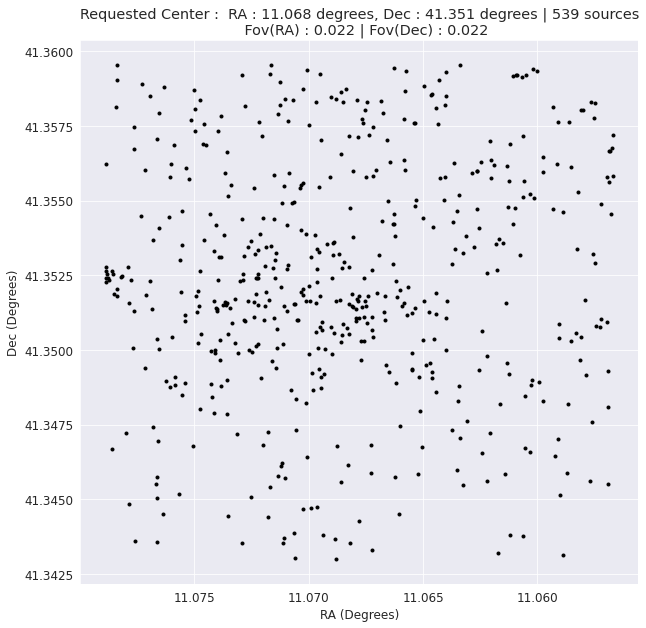

In [47]:
sim.show_field()

(<Figure size 1080x720 with 2 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7f96d089fbd0>)

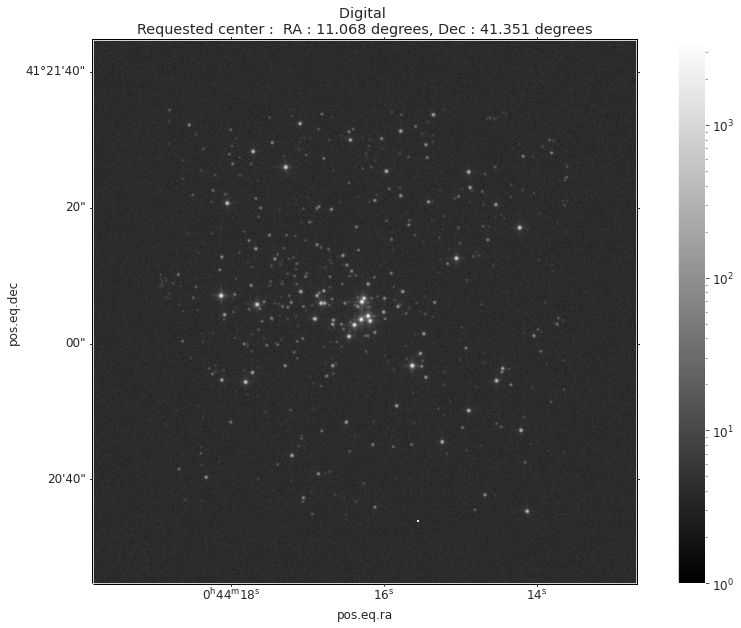

In [48]:
sim.show_image(source = 'Digital', cmap ='gray')

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f96d0aab790>)

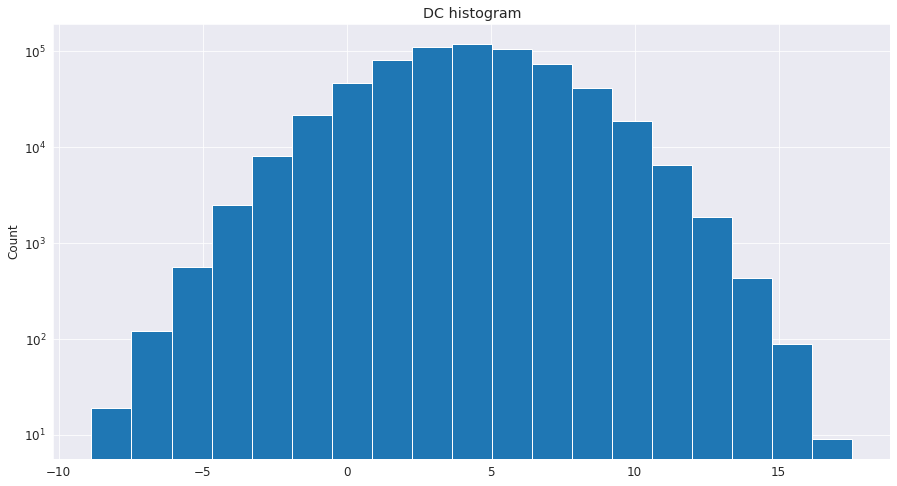

In [49]:
sim.show_hist('DC')

In [50]:
sim.phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,sky_flux,flux,flux_err,SNR,mag_in,mag_out,mag_err
,pix,pix,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64
1,638.0,105.0,3855.8571000482298,931.9128593311053,156.47790548470053,3699.3791945635294,62.09554814999405,59.575594463350974,19.441,19.207675747985803,0.018161799470848963
2,591.0,128.0,155.98868584469344,839.5504679227379,140.9692949870269,15.019390857666536,12.489543059883873,1.2025572741654957,24.539,25.186367074049805,0.899749245416061
3,576.0,129.0,895.1527447858728,844.8464658205551,141.85854836539173,753.2941964204811,29.91910334194313,25.17769960587186,21.142,20.935586318532685,0.042974537663784805
4,570.0,202.0,150.0076397208701,834.0926410985626,140.05286884117658,9.954770879693513,12.247760600243216,0.8127829408664169,24.612,25.632919700595025,1.3312287273728962
5,561.0,107.0,270.2634477331104,818.06139467013,137.3610550752084,132.902392657902,16.43969122985923,8.084238979897194,22.931,22.819165873171478,0.13384067476117087
6,552.0,253.0,3200.300801606209,915.2327651904566,153.67714340884532,3046.6236581973635,56.57120116814039,53.854675087103374,19.638,19.418450846783823,0.020091106264219345
7,549.0,195.0,181.8232002753076,827.198246273306,138.89522791902527,42.92797235628234,13.484183337351492,3.1835797009204767,23.764,24.046146933191167,0.339868984491627
8,543.0,228.0,401.3538527637825,826.7835109121081,138.82558951882413,262.5282632449584,20.033817728126174,13.104255355003346,22.216,22.080057708603533,0.08256859857259122


Text(0, 0.5, 'Output - Input (Mag)')

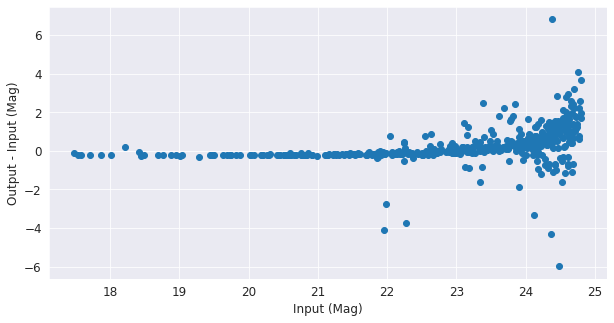

In [51]:
x = sim.phot_table['mag_in']
y = sim.phot_table['mag_out']-sim.phot_table['mag_in']

plt.figure(figsize = (10,5))
plt.scatter(x, y)
plt.xlabel('Input (Mag)')
plt.ylabel('Output - Input (Mag)')

In [36]:
sim.writeto('phatm31.fits')

## **Mosiac**

Estimated Zero point using 3 stars


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log10


Estimated Zero point using 3 stars


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log10


Estimated Zero point using 3 stars


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log10


Estimated Zero point using 3 stars
Estimated Zero point using 3 stars


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log10


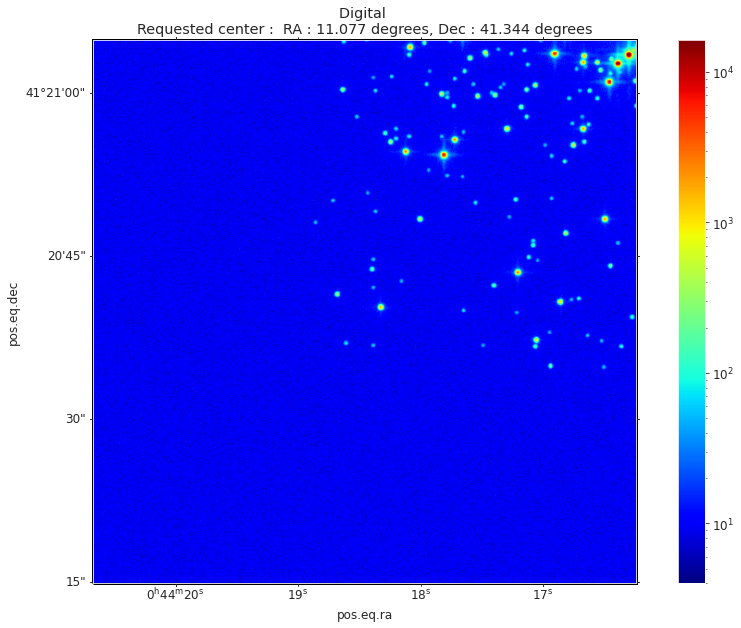

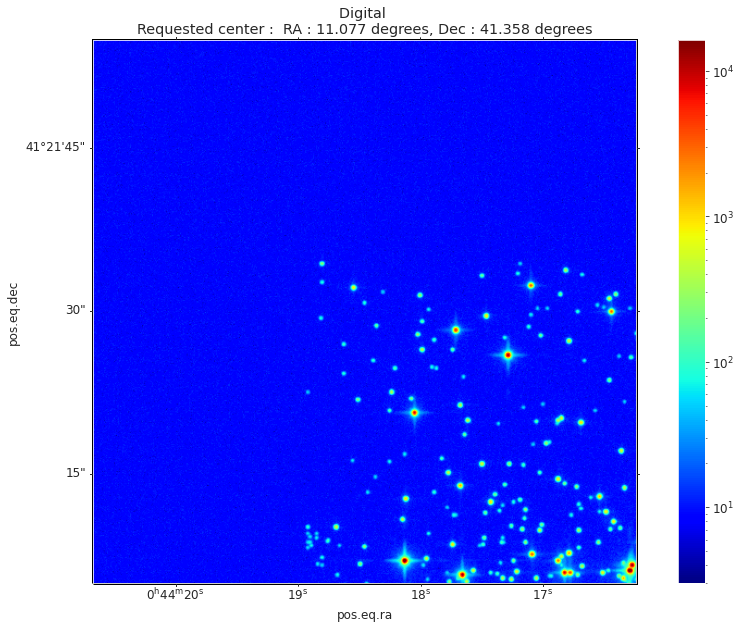

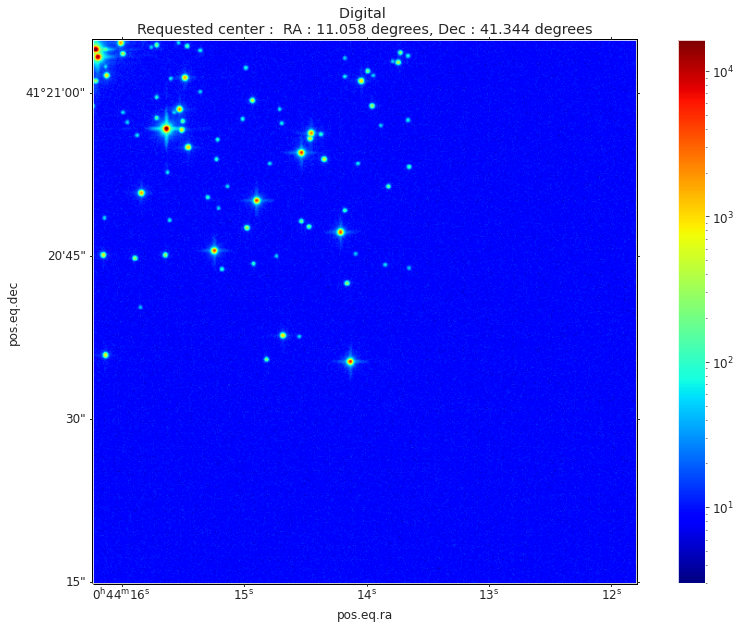

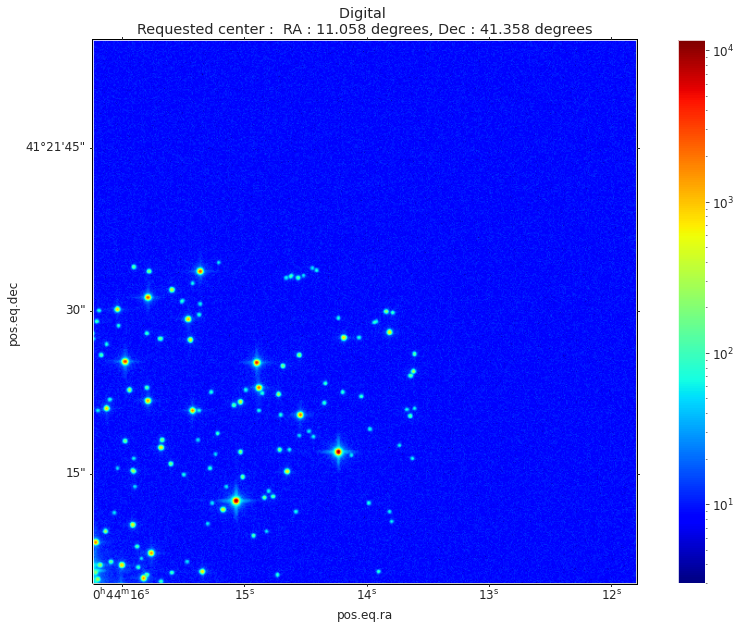

In [52]:
data_path  = '/content/INSIST/src/pista/data' 

tel_params = {'sim_file': f'{data_path}/PSF/INSIST/on_axis_hcipy.npy',
              'pixel_scale'   : 0.1,
              'response_funcs': [f'{data_path}/INSIST/UV/Coating.dat,5',
                                 f'{data_path}/INSIST/UV/Dichroic.dat,1',
                                 f'{data_path}/INSIST/UV/Filter.dat,1',
                                 f'{data_path}/INSIST/UV/QE.dat,1']}
                                  
sim = Mosaic(df = df, tel_params = tel_params, exp_time = 1000, 
             n_x  = 1000, n_y = 1000,  mos_n = 2, mos_m = 2)

sim.cosmic_rays = False
sim()

(<Figure size 1080x720 with 2 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7f96d0794e50>)

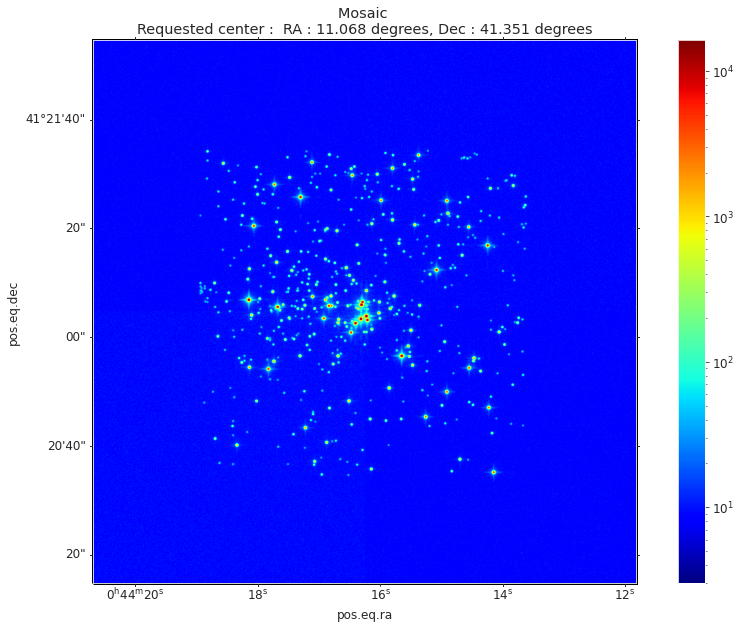

In [53]:
sim.show_mosaic()

In [54]:
sim.phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,sky_flux,flux,flux_err,SNR,mag_in,mag_out,mag_err
,pix,pix,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64
1,564.0,503.0,625.8222030297503,2709.353859600784,454.9288197090869,170.89338332066342,25.01643865600678,6.831243474363592,23.793,23.96459814260171,0.15838990427739083
2,797.0,712.0,721.8616127876601,1868.5090179843942,313.7421858555886,408.11942693207146,26.867482442306724,15.19008815985783,23.505,23.01944309209995,0.07123065966525154
3,797.0,662.0,446.5500309933928,2300.5391534381,386.2845593459497,60.26547164744312,21.131730430643696,2.851894777157034,24.509,25.09623986307082,0.3793968868229467
4,796.0,696.0,1293.5527532641004,2825.771480822316,474.4765546156874,819.076198648413,35.96599440115761,22.773628597963913,22.665,22.263100497371635,0.047511093603095675
5,795.0,616.0,453.42688207977045,1828.7410668257826,307.06473137000086,146.3621507097696,21.2938226272262,6.8734558971404,24.395,24.132839306058056,0.1574171735720528
6,794.0,692.0,2073.1919419886517,1933.6318829072768,324.6769952642816,1748.51494672437,45.53231755565108,38.40162417797596,24.395,21.439737889710845,0.028175891597328504
7,793.0,692.0,2169.041957384338,1922.0680881243652,322.73531330446434,1846.3066440798734,46.57297453872082,39.64330520793453,23.956,21.380651681156444,0.027293385209047602
8,793.0,655.0,701.9767503597114,2290.178794032746,384.54494675922973,317.4318036004817,26.494843844788207,11.980889770857194,23.54,23.29228517071985,0.09031048784305662


# **Explorative Analysis of the Simulator**

Estimated Zero point using 3 stars


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


Estimated Zero point using 3 stars


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


Estimated Zero point using 3 stars


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in sqrt


Estimated Zero point using 3 stars


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in sqrt


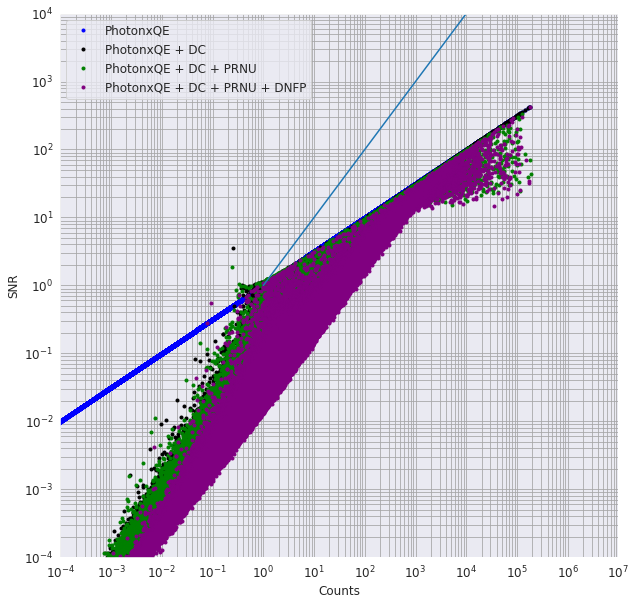

In [ ]:
fig, ax = plt.subplots(1,1)
data_path  = '/content/INSIST/src/pista/data' 

tel_params = {'sim_file': f'{data_path}/sim/INSIST/on_axis_hcipy.npy',
              'pixel_scale'   : 0.1,
              'response_funcs': [f'{data_path}/INSIST/UV/Coating.dat,5',
                                 f'{data_path}/INSIST/UV/Dichroic.dat,1',
                                 f'{data_path}/INSIST/UV/Filter.dat,1',
                                 f'{data_path}/INSIST/UV/QE.dat,1']}
                                  

det_params = {'shot_noise': 'Gaussian',
                      'M_sky'      :  27,
                      'qe_sigma'   :  0.01,       # Pixel to pixel fluctuation
                      'bias'       :  35,         # electrons
                      'G1'         :  1,
                      'bit_res'    :  14,         
                      'RN'         :  5,          # elec/pix
                      'PRNU_frac'  :  0.25/100,   # PRNU sigma
                      'T'          :  223,        # K
                      'DFM'        :  1.424e-2,   # 14.24 pA
                      'pixel_area' :  1e-6,       # 
                      'DN'         :  0.1/100,    # 
                      'NF'         :  0,          # electrons 
                      'FWC'        :  1.4e5,      # electrons 
                      'C_ray_r'    :  2/50        # hits/second
                   }

exp_time = 600
n_x      = 1000
n_y      = 1000
sim =  Analyzer(df = df, tel_params = tel_params, exp_time = exp_time, 
             n_x  = n_x, n_y = n_y)


sim.PRNU = False
sim.DNFP = False
sim.QN   = False
sim(det_params = det_params)


# Source Photoelectrons
x = (sim.source_photoelec).ravel()
y = x/np.sqrt(sim.source_photoelec).ravel()
x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)

ax.plot(x,y,'.', color ='blue')

sim = Analyzer(df = df, tel_params = tel_params, exp_time = exp_time, 
             n_x  = n_x, n_y = n_y)


sim.PRNU = False
sim.DNFP = False
sim.QN   = False

det_params = {      
              'RN'         :  5,          # elec/pix
              'PRNU_frac'  :  2/100,   # PRNU sigma
              'T'          :  223,        # K
              'DN'         :  0.1/100,    # 
            }

sim(det_params = det_params)

x = (sim.photoelec_array-sim.DC_array).ravel()
y = x/np.sqrt(sim.photoelec_array + sim.DC_array**2 ).ravel()
x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)

ax.plot(x,y,'.', color ='black')


# With PRNU
sim = Analyzer(df = df, tel_params = tel_params, exp_time = exp_time, 
             n_x  = n_x, n_y = n_y)
sim.PRNU = True
sim.DNFP = False
sim.QN   = False
sim(det_params = det_params)

x = (sim.photoelec_array-sim.DC_array).ravel()
y = x/np.sqrt(sim.photoelec_array + sim.DC_array**2+ (sim.photoelec_array*sim.PRNU_array)**2).ravel()

x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)
ax.plot(x,y,'.', color ='green')


# With PRNU and DNFP
sim = Analyzer(df = df, tel_params = tel_params, exp_time = exp_time, 
             n_x  = n_x, n_y = n_y)
sim.PRNU = True
sim.DNFP = True
sim.QN   = False
sim(det_params = det_params)

x = (sim.photoelec_array-sim.DC_array).ravel()
y = x/np.sqrt(sim.photoelec_array + sim.DC_array**2+ (sim.photoelec_array*sim.PRNU_array)**2 +  (sim.DC_array*sim.DNFP_array)**2).ravel()

x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)
ax.plot(x,y,'.', color ='purple')

x =  np.linspace(1,1e11)
y = x
plt.plot(x,y)


ax.set_xlabel('Counts')
ax.set_ylabel('SNR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-4,1e7)
ax.set_ylim(1e-4,1e4)
ax.xaxis.set_major_locator(LogLocator(numticks=15))
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10)))

plt.grid(True, which="both",axis = 'both', ls="-", color='0.65')
plt.legend(['PhotonxQE', 'PhotonxQE + DC','PhotonxQE + DC + PRNU','PhotonxQE + DC + PRNU + DNFP']);

Text(0.5, 0, 'Y')

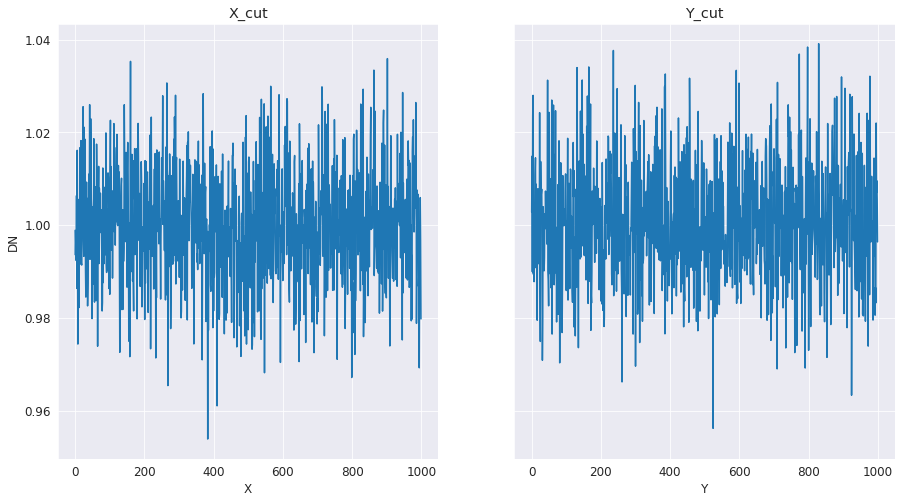

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(sim.DNFP_array[:,500])
ax[0].set_title('X_cut')
ax[0].set_xlabel('X')
ax[0].set_ylabel('DN')
ax[1].plot(sim.DNFP_array[50,:])
ax[1].set_title('Y_cut')
ax[1].set_xlabel('Y')

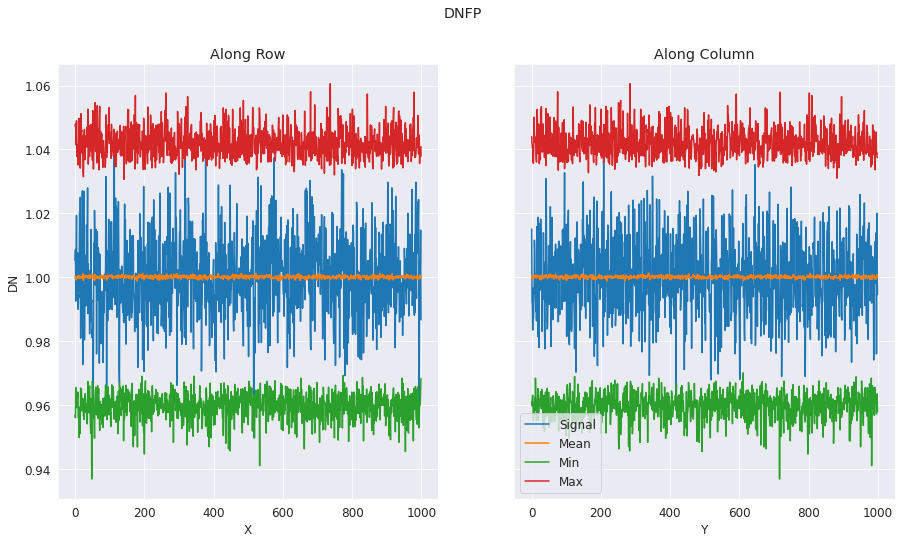

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(sim.DNFP_array[:,392])
ax[0].plot(sim.DNFP_array.mean(axis = 0))
ax[0].plot(sim.DNFP_array.min(axis = 0))
ax[0].plot(sim.DNFP_array.max(axis = 0))
ax[0].set_title('Along Row')
ax[0].set_xlabel('X')
ax[0].set_ylabel('DN')
ax[1].plot(sim.DNFP_array[392,:])
ax[1].plot(sim.DNFP_array.mean(axis = 1))
ax[1].plot(sim.DNFP_array.min(axis = 1))
ax[1].plot(sim.DNFP_array.max(axis = 1))
ax[1].set_title('Along Column')
ax[1].set_xlabel('Y')
fig.suptitle('DNFP')
plt.legend(['Signal', 'Mean','Min','Max'])

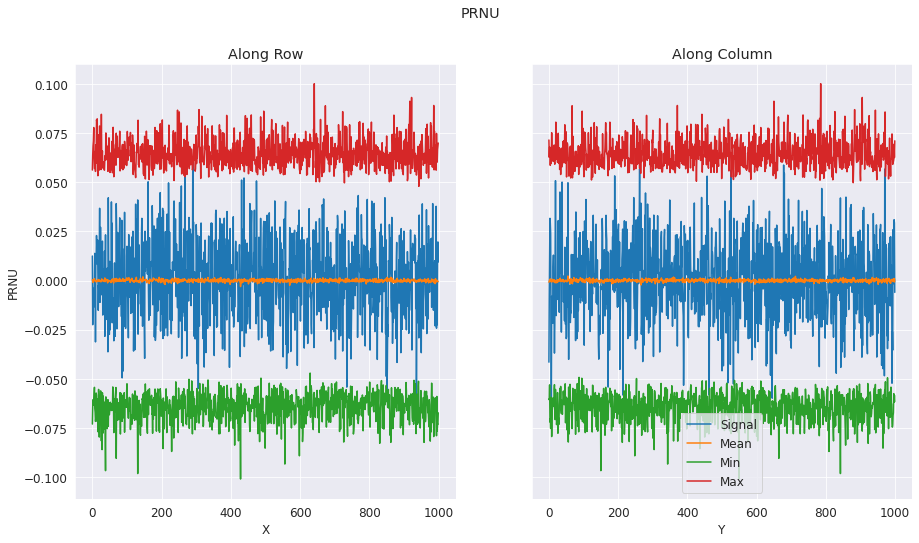

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(sim.PRNU_array[:,392])
ax[0].plot(sim.PRNU_array.mean(axis = 0))
ax[0].plot(sim.PRNU_array.min(axis = 0))
ax[0].plot(sim.PRNU_array.max(axis = 0))
ax[0].set_title('Along Row')
ax[0].set_xlabel('X')
ax[0].set_ylabel('PRNU')
ax[1].plot(sim.PRNU_array[392,:])
ax[1].plot(sim.PRNU_array.mean(axis = 1))
ax[1].plot(sim.PRNU_array.min(axis = 1))
ax[1].plot(sim.PRNU_array.max(axis = 1))
ax[1].set_title('Along Column')
ax[1].set_xlabel('Y')
fig.suptitle('PRNU')
plt.legend(['Signal', 'Mean','Min','Max'])

# **GalSim**

Work in progress

In [55]:
import galsim 

In [57]:
# Bulge
gal_flux    = 406581      # total counts on the image
rhalf       = 1.62*0.394 # arcsec
sim_sigma   = 0.2         # arcsec
 
q=0.88
g = (1-q)/(1+q)
g = abs(g)
beta = -24*np.pi/180
g1 = g*np.cos(2*beta)
g2 = g*np.sin(2*beta)

gal     = galsim.Sersic(1,flux=gal_flux, half_light_radius=rhalf)
gal     = gal.shear(g1 = g1, g2 = g2)
rot_gal = gal.rotate(beta* galsim.radians)
sim     = galsim.Gaussian(flux=1., sigma=sim_sigma) # sim flux should always = 1
bulge   = galsim.Convolve([gal, sim])

#Bar
gal_flux    = 341309      # total counts on the image
rhalf       = 5.76*0.394 # arcsec

q = 0.42
g = (1-q)/(1+q)
beta = -72*np.pi/180
g1 = g*np.cos(2*beta)
g2 = g*np.sin(2*beta)

gal     = galsim.Sersic(1,flux=gal_flux, half_light_radius=rhalf)
gal     = gal.shear(g1 = g1, g2 = g2)
rot_gal = gal.rotate(beta* galsim.radians)
sim     = galsim.Gaussian(flux=1., sigma=sim_sigma) # sim flux should always = 1
bar     = galsim.Convolve([gal, sim])

#Disk
gal_flux    = 1639787     # total counts on the image
rhalf       = 9.1312*0.394  # arcsec
sim_sigma   = 0.2         # arcsec

q = 0.8591
g = (1-q)/(1+q)
beta = 3.2633*np.pi/180
g1 = g*np.cos(2*beta)
g2 = g*np.sin(2*beta)

gal     = galsim.Sersic(1,flux=gal_flux, half_light_radius=rhalf)
gal     = gal.shear(g1 = g1, g2 = g2)
rot_gal = gal.rotate(beta* galsim.radians)
sim     = galsim.Gaussian(flux=1., sigma=sim_sigma) # sim flux should always = 1
disk     = galsim.Convolve([gal, sim])

pixel_scale = 0.394         # arcsec / pixel
noise       = 4.5         # standard 

final = galsim.Add(bulge,bar,disk)
final = final.drawImage(scale=pixel_scale)
final.addNoise(galsim.GaussianNoise(sigma=noise))

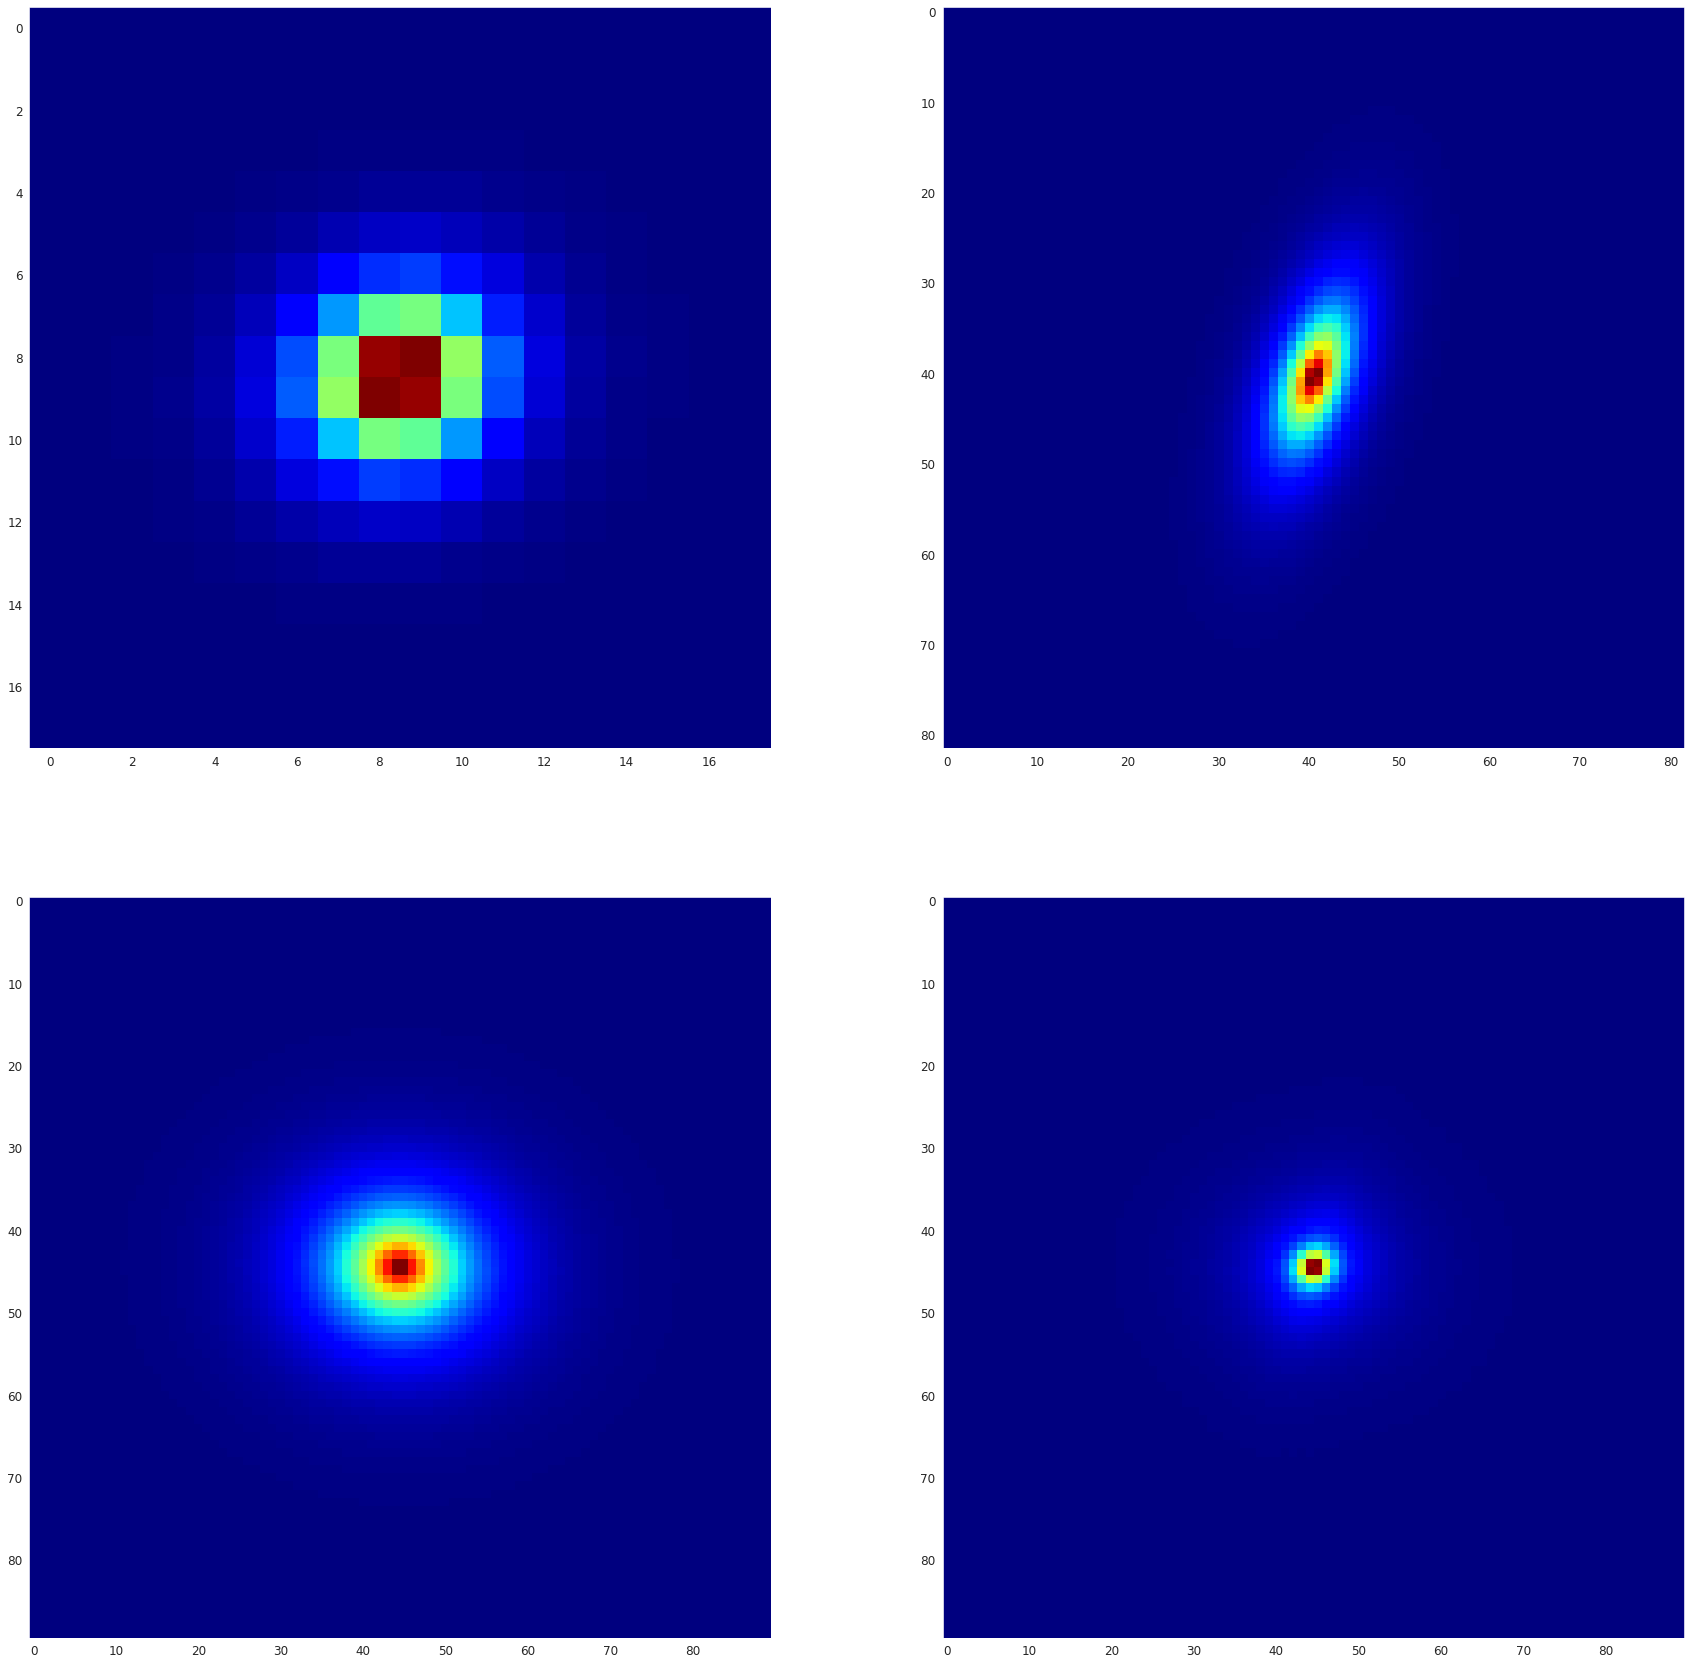

In [58]:
fig,ax= plt.subplots(2,2,figsize=(30,30))
kw={'scale':pixel_scale}
ax[0,0].imshow(bulge.drawImage(**kw).array, cmap='jet')
ax[0,0].grid(False)
ax[0,1].imshow(bar.drawImage(**kw).array, cmap='jet')
ax[0,1].grid(False)
ax[1,0].imshow(disk.drawImage(**kw).array, cmap='jet')
ax[1,0].grid(False)
ax[1,1].imshow(final.array +1000, cmap='jet')
ax[1,1].grid(False)
